<h2 style="text-align: center;"><span style="color: #333399;">Lab Course: Distributed Data Analytics</span><br /><span style="color: #333399;">Exercise Sheet 4</span></h2>
<h3 style="text-align: center;"><span style="color: #333399;">Syed Wasif Murtaza Jafri- 311226</span></h3>

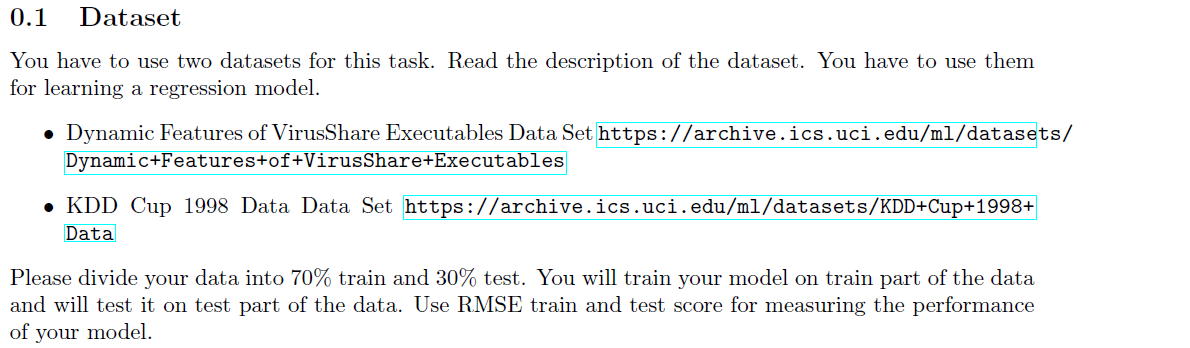

## 1 Parallel Linear Regression
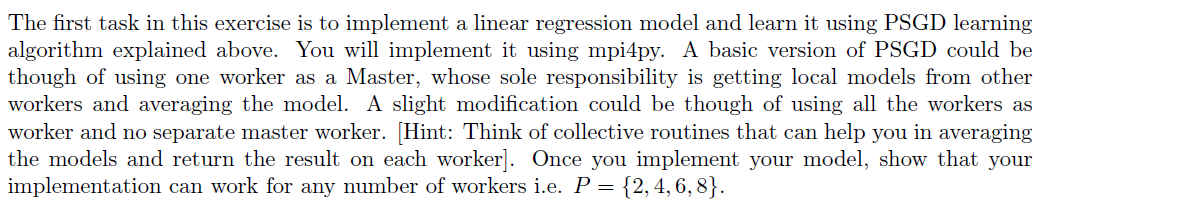

First at master, features and targets are extracted and then split into test and training. Then training and test is further divied between worker, each worker compute sgd on its chunk and update the parameters.Training and test losses are compute on each chunk and then are aggregated on master to give total training and test loss at every epoch.

In [ ]:
from cProfile import label
import math
import os
import re
import matplotlib.pyplot as plt
from mpi4py import MPI
import string
import numpy as np
import random
import sys
random.seed(0)


comm = MPI.COMM_WORLD # setting up the MPI communicator
total_worker = comm.Get_size() # getting number of workers
rank = comm.Get_rank() # storing rank of each worker
start_time = MPI.Wtime()  # time variable to find time at the end
master = 0  # master with id=0
epoch = int(sys.argv[1] )# number of epoch
numberOffeatures = 482 # total number of features in VirusShare Dataset
µ = 10**(-9) # setting value of learning rate

def getData(dir):
    '''Reading files absoulute path from dataset directory and 
    reading each file row and storing it as record in a data list'''
    data = []
    for dir_path, _, filenames in os.walk(dir):
        if len(filenames) > 0:
            for file in filenames:
                # for complete refrence of filepath
                abs_path_train = os.path.abspath(os.path.join(dir_path, file))  
                
                with open(abs_path_train, 'r',encoding='utf-8') as f:
                    Lines = f.readlines()
                    
                    for line in Lines:
                        #removing linespace and adding to list
                        data.append(line.strip('\n'))
        
    return data
def getFeaturesAndTargets(data):
    ''' Reading each line of VirusShare dataset and extracting Targets Y 
    which are first element of every row and Features X which
    position and values are separated by colon ':' '''
    
    Y = np.zeros((len(data),1),dtype=np.float16)
    X = np.zeros((len(data),numberOffeatures),dtype=np.int16)

    row = 0
    for d in data:
        columns = d.split(' ')
        
        # extracting Y targets for every row in data
        Y[row] = float(columns[0])
        
        # extracting X features for every row in data
        col = 0
        for i in range(1,len(columns)):
            if columns[i]!= '':
                featureIndex = int(columns[i].split(':')[0])  
                featureValue = int(columns[i].split(':')[1])
                X[row][featureIndex] = featureValue
        row += 1

    return X,Y

def calculateChunks(data):
    # Calculating chunk size for each worker
    chunk_size = len(data) // total_worker
    
    chunkList = []
    for i in range(1,total_worker+1 ): 
        
        if i== total_worker:
            # for not equaly divided dataset rows, for last chunk adding all remaing items 
            chunkList.append(data[(i - 1) * chunk_size:])
        else:
            chunkList.append(data[(i - 1) * chunk_size:i * chunk_size])
    
    return chunkList

def squaredLoss(X,Y,B):
    ''' Computes squared loss between prediction and actual targets Y'''
    
    return np.sum((Y - np.dot( X, B.T))**2)

def lossGrad(X,Y,B):
    '''Computes gradient of Loss function with respect to paramtere B for 1 instance of SGD'''
    
    return (-2) * ( Y.item() - np.dot( X, B.T).item() ) * X

    
def stochasticGradDecent(dataTrain,µ,B):
    '''Computes Stochastic Gradient Decent step for 
    one chunk of Training data and return updated Parameter B'''
    
    B_new =np.empty(B.shape)
    
    for j in range(len(dataTrain)):
        B_new =  B - (µ * lossGrad(dataTrain[j,:-1].reshape(1,numberOffeatures+1) , dataTrain[j,-1:] , B) )

    return B_new

if rank == master:
    # reading dataset from directory and storing it in data list
    data = getData('Dataset')
    
    # extracting features X and targets Y
    X,Y = getFeaturesAndTargets(data)
    
    # adding Bias column B0 of ones in X
    bias_column = np.ones( shape=(len(X) , 1))
    X = np.append(bias_column,X,axis=1)

    # appending X and Y toghether so that index of X and its target Y remains same after shuffling
    data = np.append(X,Y,axis=1)

    # splitting data into training and test splits with 80:20 ratio
    dataTrain = data[0 : math.floor(len(data)*0.8), : ]
    dataTest = data[math.floor(len(data)*0.8) + 1 :, : ]
    
    # initializing param B with zeros
    B = np.zeros((1,numberOffeatures+1))
    
    # storing length of training data for RMSE calculation
    lenTrain = len(dataTrain)
else:
    B=None
    

trainLoss = []
testLoss = []
iteration=0

# broadcasting param B to all workers
B = comm.bcast(B, root=0)

while iteration < epoch :
    iteration+=1
    
    if rank == master:
        chunkListTrain = calculateChunks(dataTrain)
        chunkListTest = calculateChunks(dataTest)

    else:
        chunkListTrain = None
        chunkListTest = None

    # scattering data chunks to all workers 
    dataTrain = comm.scatter(chunkListTrain,root=0)
    dataTest = comm.scatter(chunkListTest,root=0)

    # shuffling dataset 
    np.random.shuffle(dataTrain)
    
    # computing updated param B after SGD step 
    B = stochasticGradDecent (dataTrain,µ,B) 
    
    # calculating squared loss for trainin data for each worker    
    traningsquareloss = squaredLoss(dataTrain[:,:-1].reshape(len(dataTrain),numberOffeatures+1),dataTrain[:,-1:],B)
    totalTraningSquaredLoss= np.zeros(1)
    
    # adding squared loss from each workers at master
    comm.Reduce(traningsquareloss,totalTraningSquaredLoss,op=MPI.SUM, root=0)
    
    # calculating squared loss for trainin data for each worker    
    testgsquareloss = squaredLoss(dataTest[:,:-1].reshape(len(dataTest),numberOffeatures+1),dataTest[:,-1:],B)
    totalTestSquaredLoss= np.zeros(1)
    
    # adding squared loss from each workers at master
    comm.Reduce(testgsquareloss,totalTestSquaredLoss,op=MPI.SUM, root=0)

    # computing sum of param B from each worker at master
    B_avg = np.empty((1,numberOffeatures+1))
    comm.Reduce(B,B_avg,op=MPI.SUM, root=0)
    
    if rank == master:
        # computed train rmse and appending to list for plotting for each epoch
        trainLoss.append(np.sqrt(totalTraningSquaredLoss/lenTrain))
        
        # computed test rmse and appending to list for plotting for each epoch
        testLoss.append(np.sqrt(totalTestSquaredLoss/lenTrain))
        
        # computing average of param B from each worker by dividing with total number of workers at master
        B = B_avg/total_worker
    else:
        B = None
    # broadcasting Param B to each worker for next epoch
    B = comm.bcast(B, root=0)

 

    
if rank == 0:
    print('******************** Experiment *************************')
    print('Total Number of Workers : ',  total_worker )
    print('Total Epochs',epoch)
    totalTime = MPI.Wtime() - start_time
    print('Total Execution Time : ',  MPI.Wtime() - start_time )
    mode = 'w'  if total_worker==1 else 'a'
    with open('Timefor'+str(epoch)+'epochs.txt', mode) as f:
        f.write(str(total_worker) +','+str(totalTime) + '\n')
        
    ## plotting train and test loss convergence    
    plt.plot(trainLoss,label = 'Train')
    plt.plot(testLoss,label = 'Test')
    plt.title('PSGD Convergence Plot for '+str(total_worker) +' Workers')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.rcParams["figure.figsize"] = (25,25)
    plt.savefig('PSGD Convergence Plot for '+str(total_worker) +' Workers,' +str(epoch)+'Epochs'+ '.png')


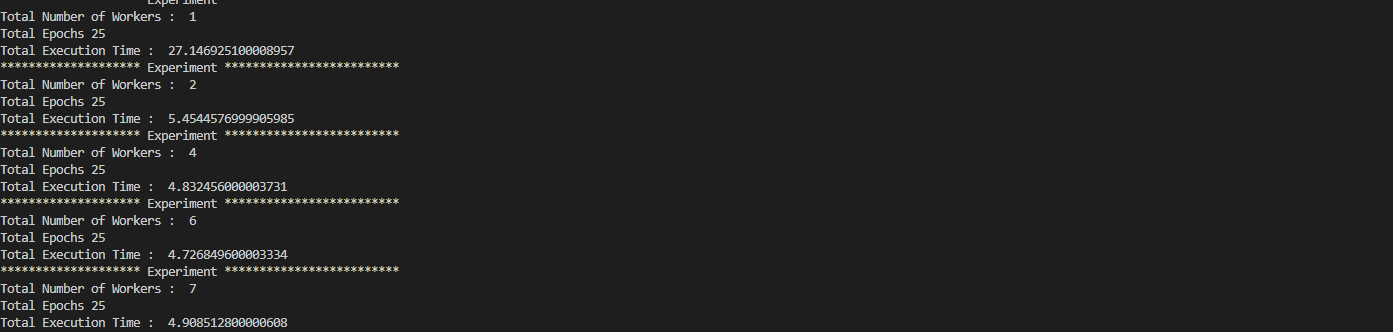

## 2 Performance and convergence of PSGD
### Sequential SDG convergence for 10 Epochs
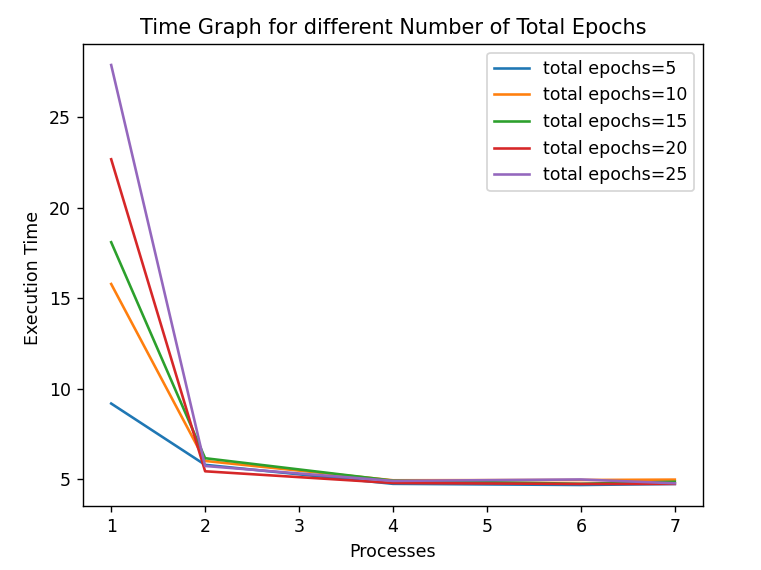

#### Scales are different for training and test loss hence different sublplots are shown.

## Paralell SGD convergence for Different Workers and 10 Epochs
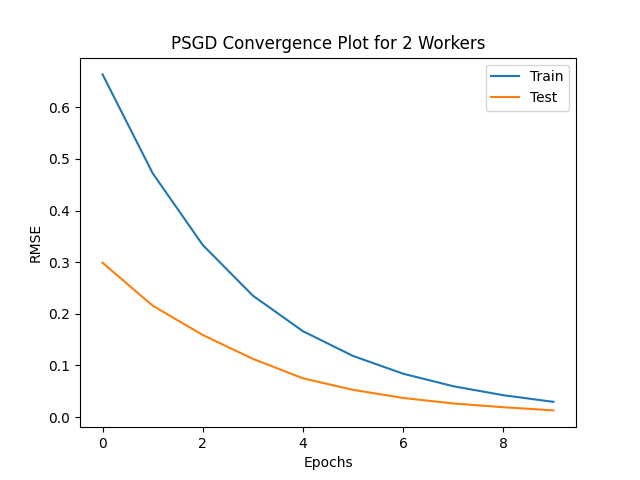
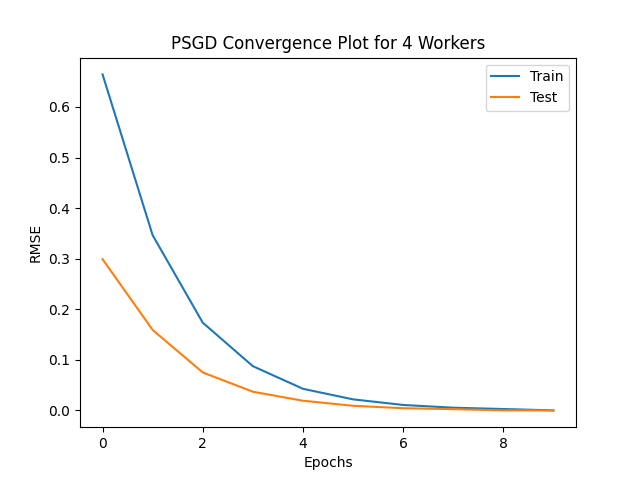
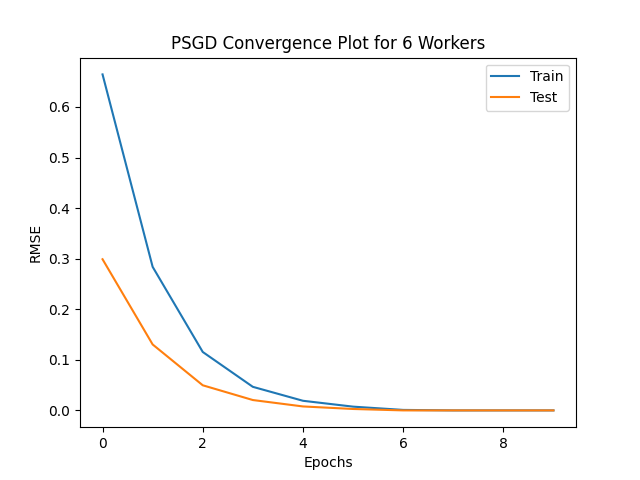
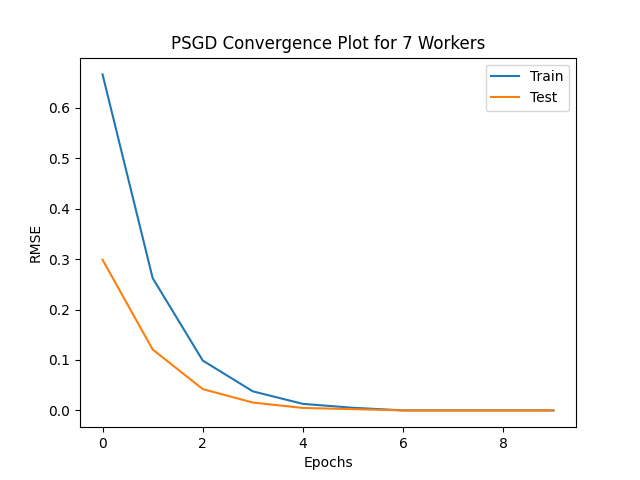

#### As shown in above graphs, increasing number of workers, model is converging in lesser epochs.

In [52]:
import pandas as pd
worker_cluster = {1:[5,9.173388499999419,5.783826600003522,4.731246400013333,4.667742399993585,4.723458600026788],
                2:[10,15.785988300020108,5.997114900004817,4.929294200002914,4.944732000003569,4.965868700004648],
                3:[15,18.096943200012902,6.149866899999324,4.90788009998505,4.7369829999806825,4.848693200008711],
                4:[20,22.686107500019716,5.425975199992536,4.778923600009875,4.7255362999858335,4.729834500001743],
                5:[25,27.899946999998065,5.719417999993311,4.894090099987807,4.974020699999528,4.762656600010814] }

time = pd.DataFrame.from_dict(worker_cluster, orient = 'index')
time.columns = ['TotalEpochs','p:1', 'p:2', 'p:4', 'p:6', 'p:7']
time2 = time.style.set_properties(**{
    'background-color': '#639be0',
    'font-size': '16pt'

})
time2.background_gradient(axis=None, vmin=1, vmax=29, cmap="YlGnBu")


,TotalEpochs,p:1,p:2,p:4,p:6,p:7
1,5,9.173388,5.783827,4.731246,4.667742,4.723459
2,10,15.785988,5.997115,4.929294,4.944732,4.965869
3,15,18.096943,6.149867,4.907880,4.736983,4.848693
4,20,22.686108,5.425975,4.778924,4.725536,4.729835
5,25,27.899947,5.719418,4.894090,4.974021,4.762657


Text(0.5, 1.0, 'Epochs Vs Time')

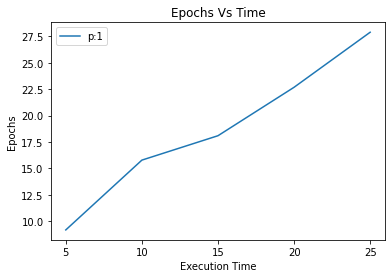

In [56]:
ax = time[['TotalEpochs', 'p:1']].plot(x='TotalEpochs', y='p:1',xticks=[5,10,15,20,25])
ax.set_xlabel("Execution Time")
ax.set_ylabel("Epochs")
ax.set_title('Epochs Vs Time')


#### For every worker time is increasing in every column with increase in epochs, but for sequential execution time this increase larger.
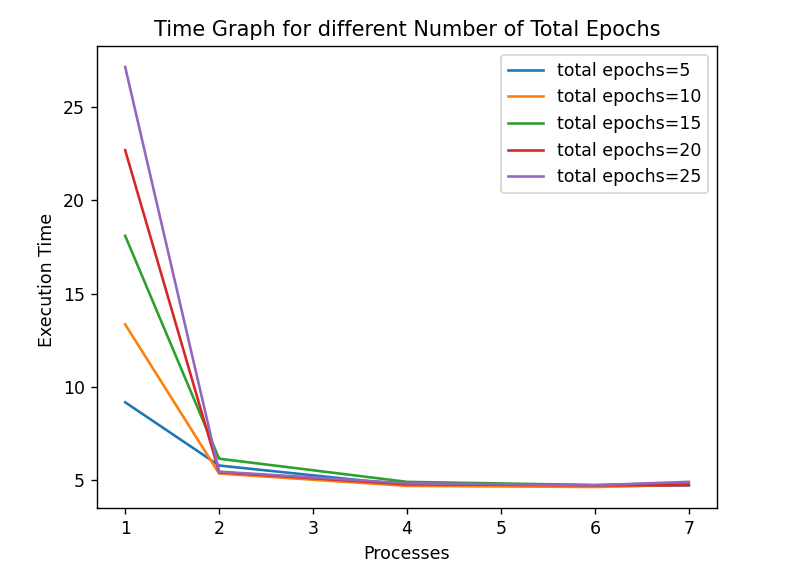

### KDD Cup 1998 Dataset

For KDD dataset, first we transform the dataframe and remove null values and convert categorical data into numerical. Then after converting to Numpy array X and Y, rest is same as VirusShare dataset.

In [ ]:
import numpy as np
import pandas as pd


def transformData (df):
    ''' Transform dataframe by removing categorical columns with integer values and also replacing Nan values with 0'''
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    colList = list(set(cols) - set(num_cols))
    dictMap = dict()
    for c in colList :
        keys = df[c].unique()
        values = list(range(0, len(keys)))
        dictionary = dict(zip(keys, values))
        dictMap.update(dictionary)
        df[c]=df.apply(lambda x: dictMap.get(x[c]),axis=1)

    return df.fillna(0)



# reading dataframe from directory and storing it in data list
df = pd.read_csv('cup98LRN.txt', sep = ',')
data = transformData(df)
data.to_csv(r'transformedDataset2.txt', header=True, index=None, sep=',', mode='w')

In [ ]:
from cProfile import label
import math
import pandas as pd
from turtle import color
import matplotlib.pyplot as plt
from mpi4py import MPI
import string
import numpy as np
import random
import sys
random.seed(0)
np.printoptions(threshold=10)


comm = MPI.COMM_WORLD # setting up the MPI communicator
total_worker = comm.Get_size() # getting number of workers
rank = comm.Get_rank() # storing rank of each worker
start_time = MPI.Wtime()  # time variable to find time at the end
master = 0  # master with id=0
epoch = int(sys.argv[1] )# number of epoch
numberOffeatures = 480 # total number of features in VirusShare Dataset
µ = 10**(-9) # setting value of learning rate


def calculateChunks(data):
    # Calculating chunk size for each worker
    chunk_size = len(data) // total_worker
    
    chunkList = []
    for i in range(1,total_worker+1 ): 
        
        if i== total_worker:
            # for not equaly divided dataset rows, for last chunk adding all remaing items 
            chunkList.append(data[(i - 1) * chunk_size:])
        else:
            chunkList.append(data[(i - 1) * chunk_size:i * chunk_size])
    
    return chunkList

def squaredLoss(X,Y,B):
    ''' Computes squared loss between prediction and actual targets Y'''
    
    return np.sum((Y - np.dot( X, B.T))**2)

def lossGrad(X,Y,B):
    '''Computes gradient of Loss function with respect to paramtere B for 1 instance of SGD'''
    
    return (-2) * ( Y.item() - np.dot( X, B.T).item() ) * X

    
def stochasticGradDecent(dataTrain,µ,B):
    '''Computes Stochastic Gradient Decent step for 
    one chunk of Training data and return updated Parameter B'''
    
    B_new =np.empty(B.shape)
    
    for j in range(len(dataTrain)):
        B_new =  B - (µ * lossGrad(dataTrain[j,:-1].reshape(1,numberOffeatures+1) , dataTrain[j,-1:] , B) )

    return B_new

if rank == master:
    # reading dataset from directory and storing it in data list
    df = pd.read_csv('transformedDataset2.txt', sep = ',')
    
    # extracting features X and targets Y
    X = df.loc[:, df.columns != 'TARGET_D'].to_numpy()
    Y = df[['TARGET_D']].to_numpy()
    
    # adding Bias column B0 of ones in X
    bias_column = np.ones( shape=(len(X) , 1))
    X = np.append(bias_column,X,axis=1)

    # appending X and Y toghether so that index of X and its target Y remains same after shuffling
    data = np.append(X,Y,axis=1)

    # splitting data into training and test splits with 80:20 ratio
    dataTrain = data[0 : math.floor(len(data)*0.8), : ]
    dataTest = data[math.floor(len(data)*0.8) + 1 :, : ]
    
    # initializing param B with zeros
    B = np.zeros((1,numberOffeatures+1))
    
    # storing length of training data for RMSE calculation
    lenTrain = len(dataTrain)
else:
    B=None
    

trainLoss = []
testLoss = []
iteration=0

# broadcasting param B to all workers
B = comm.bcast(B, root=0)

while iteration < epoch :
    iteration+=1
    
    if rank == master:
        chunkListTrain = calculateChunks(dataTrain)
        chunkListTest = calculateChunks(dataTest)

    else:
        chunkListTrain = None
        chunkListTest = None

    # scattering data chunks to all workers 
    dataTrain = comm.scatter(chunkListTrain,root=0)
    dataTest = comm.scatter(chunkListTest,root=0)

    # shuffling dataset 
    np.random.shuffle(dataTrain)
    
    # computing updated param B after SGD step 
    B = stochasticGradDecent (dataTrain,µ,B) 
    
    # calculating squared loss for trainin data for each worker    
    traningsquareloss = squaredLoss(dataTrain[:,:-1].reshape(len(dataTrain),numberOffeatures+1),dataTrain[:,-1:],B)
    totalTraningSquaredLoss= np.zeros(1)
    
    # adding squared loss from each workers at master
    comm.Reduce(traningsquareloss,totalTraningSquaredLoss,op=MPI.SUM, root=0)
    
    # calculating squared loss for trainin data for each worker    
    testgsquareloss = squaredLoss(dataTest[:,:-1].reshape(len(dataTest),numberOffeatures+1),dataTest[:,-1:],B)
    totalTestSquaredLoss= np.zeros(1)
    
    if total_worker>1:
        # adding squared loss from each workers at master
        comm.Reduce(testgsquareloss,totalTestSquaredLoss,op=MPI.SUM, root=0)
    else:
        totalTestSquaredLoss = testgsquareloss

    if total_worker>1:
        # computing sum of param B from each worker at master
        B_avg = np.empty((1,numberOffeatures+1))
        comm.Reduce(B,B_avg,op=MPI.SUM, root=0)
    else:
        B_avg=B

    
    if rank == master:
        # computed train rmse and appending to list for plotting for each epoch
        trainLoss.append(np.sqrt(totalTraningSquaredLoss/lenTrain))
        
        # computed test rmse and appending to list for plotting for each epoch
        testLoss.append(np.sqrt(totalTestSquaredLoss/lenTrain))
        
        # computing average of param B from each worker by dividing with total number of workers at master
        B = B_avg/total_worker
    else:
        B = None
    # broadcasting Param B to each worker for next epoch
    B = comm.bcast(B, root=0)

 

    
if rank == 0:
    print('******************** Experiment *************************')
    print('Total Number of Workers : ',  total_worker )
    print('Train Loss : ', trainLoss )
    print('Test Loss : ', trainLoss )
    print('Total Epochs',epoch)
    totalTime = MPI.Wtime() - start_time
    print('Total Execution Time : ',  MPI.Wtime() - start_time )
    mode = 'w'  if total_worker==1 else 'a'
    with open('Timefor'+str(epoch)+'epochs.txt', mode) as f:
        f.write(str(total_worker) +','+str(totalTime) + '\n')
        
    # plotting train and test loss convergence    
    plt.plot(trainLoss,label = 'Train')
    plt.subplot(1, 2, 1)
    plt.title('PSGD Convergence Plot for '+str(total_worker) +' Workers')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.rcParams["figure.figsize"] = (25,25)
    plt.savefig('PSGD Convergence Plot for '+str(total_worker) +' Workers,' +str(epoch)+'Epochs'+ '.png')

# print(trainLoss[0:10])

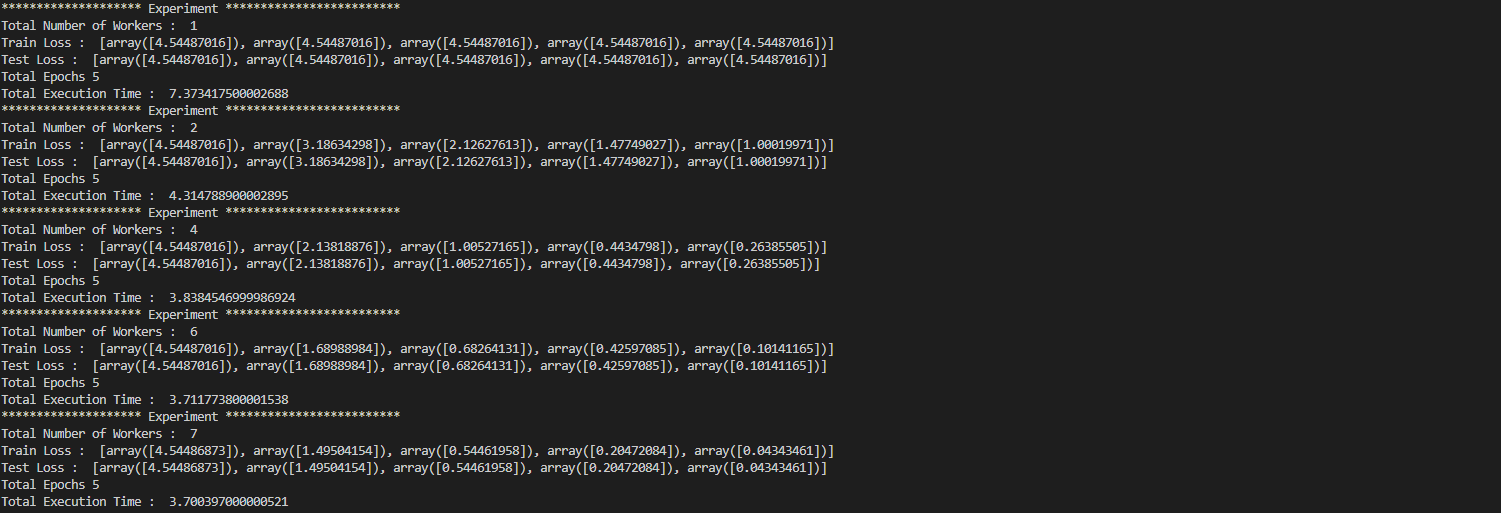

## 2 Performance and convergence of PSGD
### Sequential SDG convergence for 10 Epochs
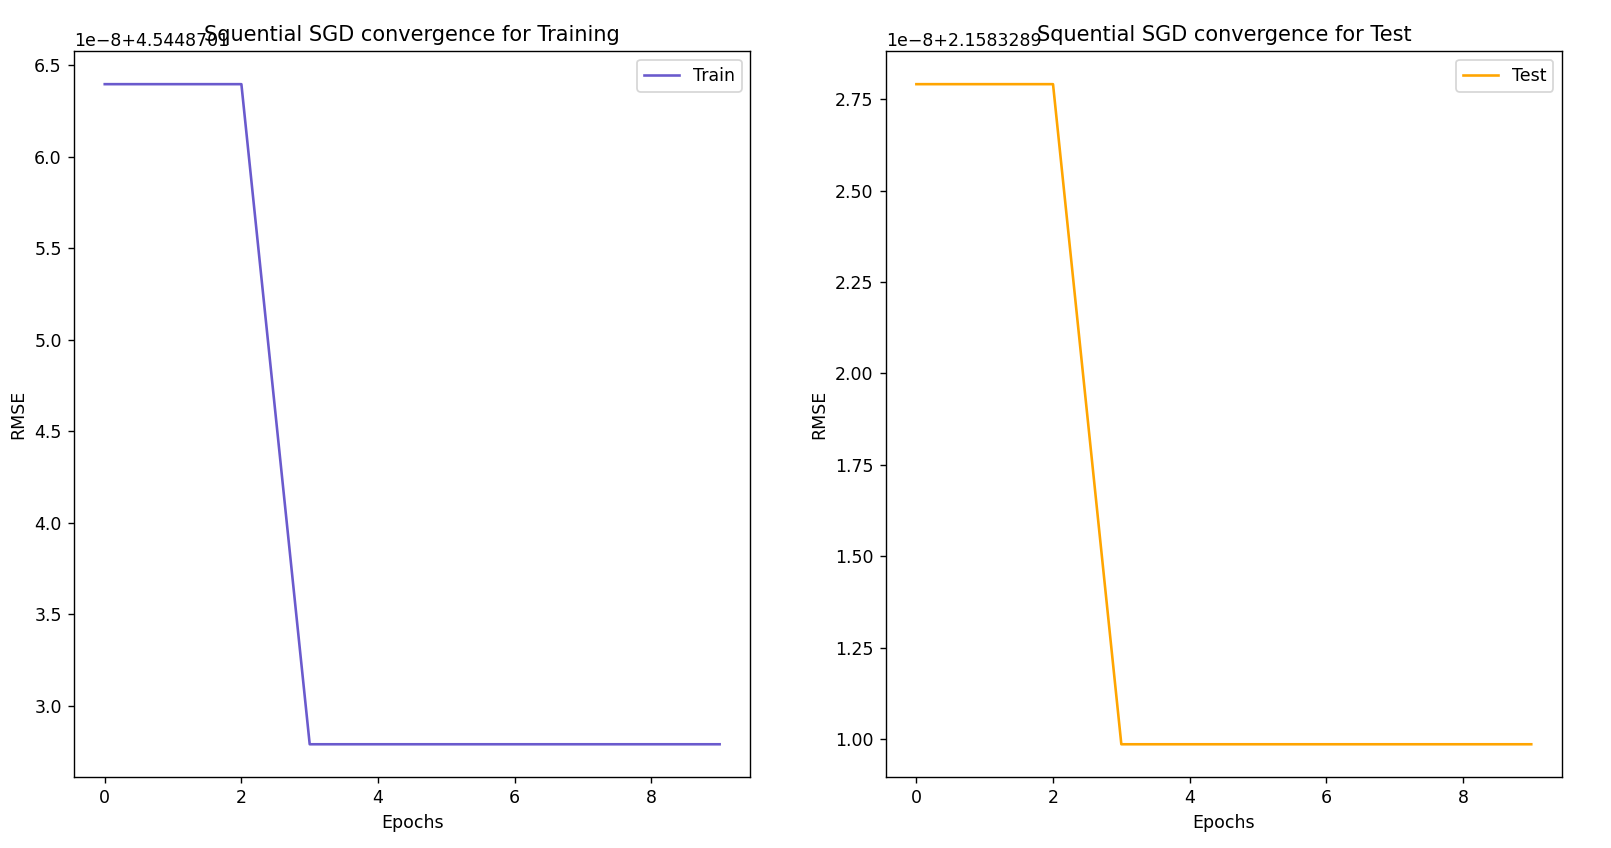

#### Scales are different for training and test loss hence different sublplots are shown.

## Paralell SGD convergence for Different Workers and 10 Epochs
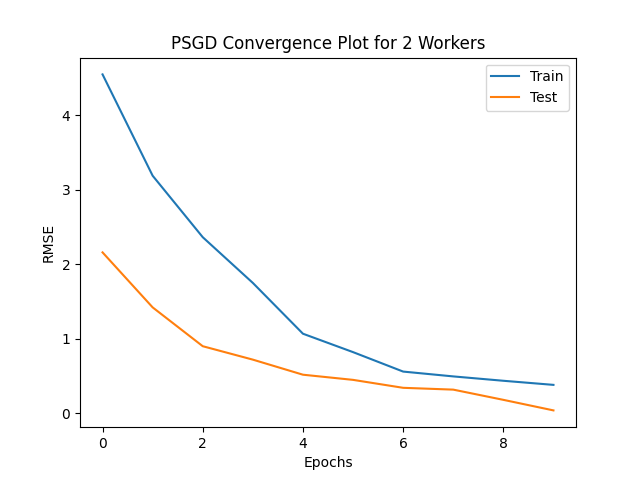
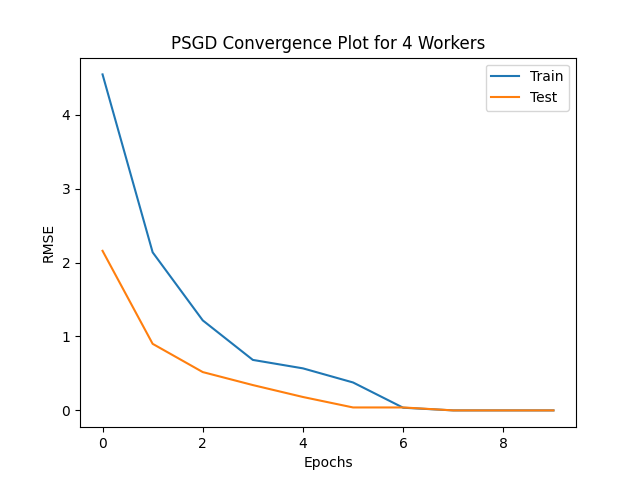
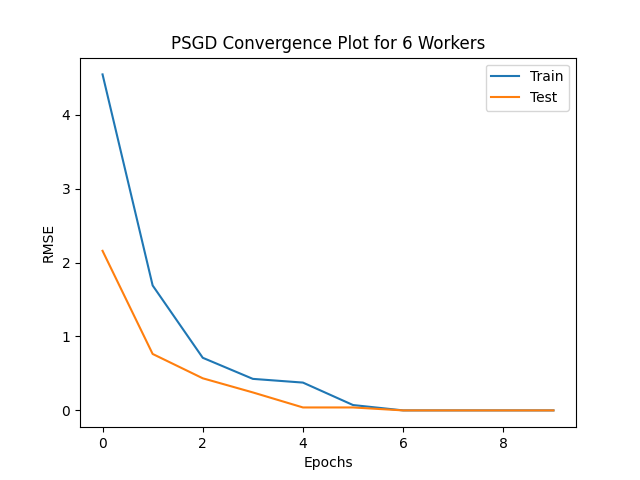
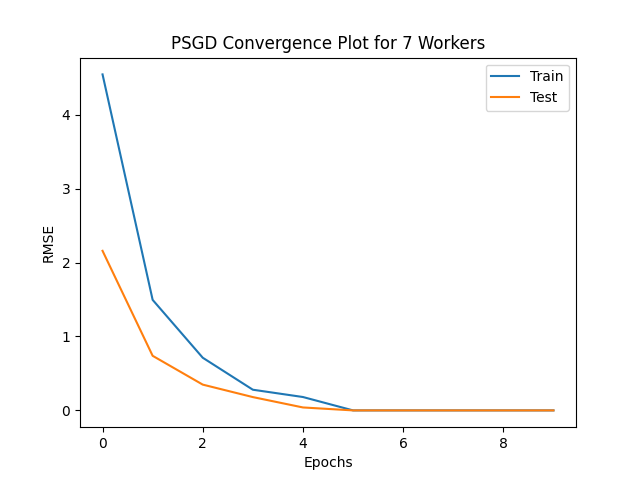

#### As shown in above graphs, increasing number of workers, model is converging in lesser epochs.

In [7]:
import pandas as pd
worker_cluster = {1:[5,7.373416800000996,4.314788200001203,3.838453699998354,3.711772499998915,3.700395399999252],
                2:[10,11.727130899998883,4.561679200000071,3.8760756999981822,3.812437200002023,3.9485558999986097],
                3:[15,16.35898240000097,4.441436900000554,3.8372896000000765,3.8564231999989715,3.844564099999843],
                4:[20,20.604837800001405,4.6310374999993655,4.134574299998349,3.8458694000000833,3.872903400002542],
                5:[25,25.645451799999137,4.910505499999999,3.9053528000004007,4.40742870000031,3.9820811999998114] }

time = pd.DataFrame.from_dict(worker_cluster, orient = 'index')
time.columns = ['TotalEpochs','p:1', 'p:2', 'p:4', 'p:6', 'p:7']
time2 = time.style.set_properties(**{
    'background-color': '#639be0',
    'font-size': '16pt'

})
time2.background_gradient(axis=None, vmin=1, vmax=29, cmap="YlGnBu")


,TotalEpochs,p:1,p:2,p:4,p:6,p:7
1,5,7.373417,4.314788,3.838454,3.711772,3.700395
2,10,11.727131,4.561679,3.876076,3.812437,3.948556
3,15,16.358982,4.441437,3.837290,3.856423,3.844564
4,20,20.604838,4.631037,4.134574,3.845869,3.872903
5,25,25.645452,4.910505,3.905353,4.407429,3.982081


Text(0.5, 1.0, 'Epochs Vs Time')

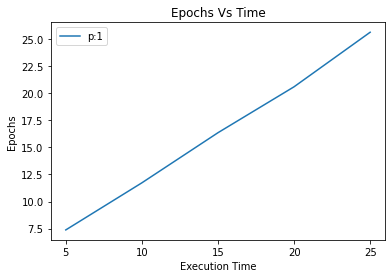

In [12]:
ax = time[['TotalEpochs', 'p:1']].plot(x='TotalEpochs', y='p:1',xticks=[5,10,15,20,25])
ax.set_xlabel("Execution Time")
ax.set_ylabel("Epochs")
ax.set_title('Epochs Vs Time')


#### For every worker time is increasing in every column with increase in epochs, but for sequential execution time this increase larger.


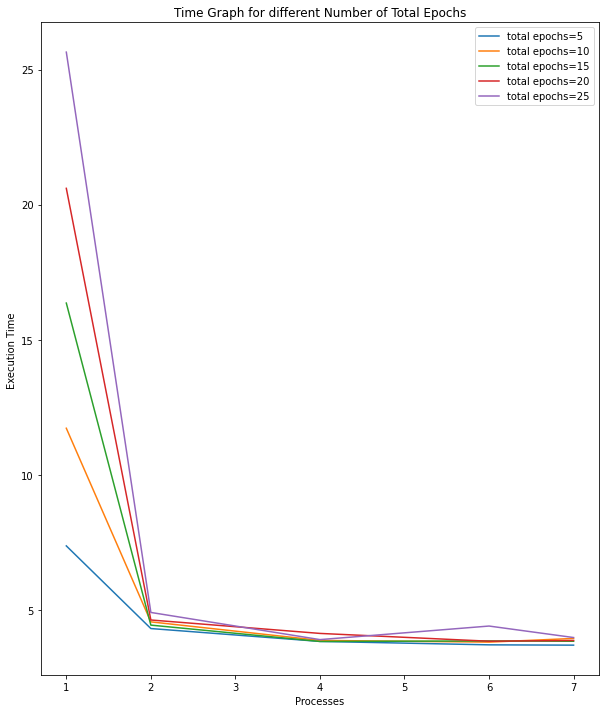

In [20]:
import numpy as np
from matplotlib import pyplot as plt
epochesNumberList = [5,10,15,20,25]
timeLiist = []
for i in epochesNumberList:
    with open('Timefor'+str(i)+'epochs.txt', 'r') as f:
        Lines = f.readlines()
        timeList = []
        for line in Lines:
            timeList.append([float(x) for x in line.strip().split(',')])
    
    workers = np.array(timeList)[:,0]
    executionTime = np.array(timeList)[:,1]

    timeLiist.append(executionTime)
    

for i in range(len(timeLiist)):
    plt.plot(workers, timeLiist[i], label='total epochs='+str(epochesNumberList[i]))
plt.title('Time Graph for different Number of Total Epochs')
plt.xlabel('Processes')
plt.ylabel('Execution Time ')
plt.legend()
plt.rcParams["figure.figsize"] = (15,12)
plt.show()